**Project Check-in 3**

In [1]:
%pip install --upgrade pip
%pip install scikit-lego
%pip install seaborn
%pip install nbstripout
!nbstripout --install

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
fatal: --local can only be used inside a git repository
Installation failed: not a git repository!


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("./dataset.csv")

1. In Check-in 3, we chose explicit as our binary response variable.

2. We chose "Speechiness" as our predictor because we thought it might indicate whether or not a track was rap, which generally has more explicit lyrics.

3. See below.

In [27]:
# Step 1: Clean Data
# Remove duplicates
df_cleaned = df.drop_duplicates()

# Remove columns with every row unique. Also dropping artist and album because it would be too much one-hot encoding
df_cleaned.drop(columns=['track_id', 'track_name', 'artists','album_name'], inplace=True)

# We will now One-Hot Encode the categorical variables

#The columns with object datatype will be categorical
cat_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Initialize and use OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df_cleaned[cat_columns])

# We now replace the original df with one that is one hot encoded.
# We will use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_columns))

# We now add the OneHotEncoded columns and drop the old ones
df_encoded = pd.concat([df_cleaned, one_hot_df], axis=1)
df_encoded = df_encoded.drop(cat_columns, axis=1)

# Step 2: Define Predictor (everything but response) and Response
y = df_encoded['explicit']     # binary response
X = df_encoded
X.drop(columns=['explicit'], inplace = True) #predictor

# Split data into training and testing sets (optional, here we'll use all data for training)
# 60% train, 20% test, 20% validation
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, train_size=0.6, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X, y, train_size=0.5, random_state=42)

# Step 3: Train KNN Model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Step 4: Predict and Evaluate
y_pred = knn_model.predict(X_train)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_pred)
prediction_error = 1 - accuracy
TPR = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])  # True Positive Rate
TNR = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # True Negative Rate

# Print results
print("Confusion Matrix:\n", conf_matrix)
print("Prediction Accuracy:", accuracy)
print("Prediction Error:", prediction_error)
print("True Positive Rate (TPR):", TPR)
print("True Negative Rate (TNR):", TNR)

Confusion Matrix:
 [[61651   869]
 [ 3231  2649]]
Prediction Accuracy: 0.9400584795321637
Prediction Error: 0.059941520467836296
True Positive Rate (TPR): 0.45051020408163267
True Negative Rate (TNR): 0.9861004478566858


#4 See below

[0.         0.         0.66666667 ... 0.         0.         0.        ]


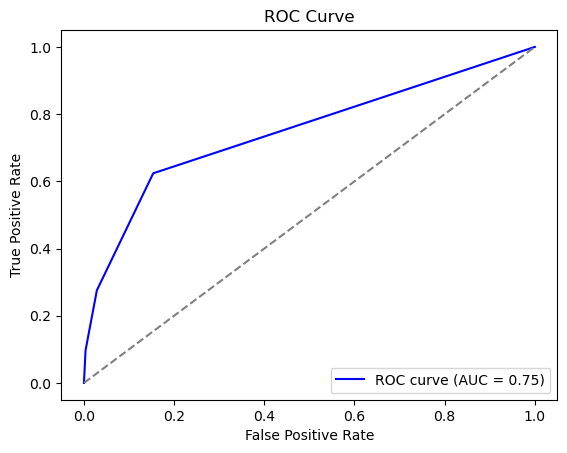

5-Fold Cross-Validation AUC scores: [0.68888548 0.70989064 0.69646417 0.69571819 0.69000559]
Mean AUC across folds: 0.6961928140246731
5-Fold Cross-Validation Accuracy scores: [0.90798246 0.90991228 0.90587719 0.90438596 0.90385965]
Mean Accuracy across folds: 0.9064035087719299


In [29]:
# Perform 5-fold cross-validation on the validation set for AUC and accuracy
cv = StratifiedKFold(n_splits=5)
auc_scores = cross_val_score(knn_model, X_val, y_val, cv=cv, scoring='roc_auc')
accuracy_scores = cross_val_score(knn_model, X_val, y_val, cv=cv, scoring='accuracy')

# Train model on training data for ROC curve
knn_model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_val_probs = knn_model.predict_proba(X_val)[:, 1]
print(y_val_probs)

# Calculate ROC curve and AUC on the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = roc_auc_score(y_val, y_val_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print cross-validated AUC and accuracy for each fold
print("5-Fold Cross-Validation AUC scores:", auc_scores)
print("Mean AUC across folds:", np.mean(auc_scores))
print("5-Fold Cross-Validation Accuracy scores:", accuracy_scores)
print("Mean Accuracy across folds:", np.mean(accuracy_scores))


In [30]:
# Precision-recall curve gives thresholds, precision, and recall
y_prob = knn_model.predict_proba(X_train)[:, 1]
precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the threshold that maximizes the F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]

# Step 4: Use optimal threshold for predictions
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Print the results
print("Optimal Threshold (F1):", optimal_threshold)
print("F1 Score at Optimal Threshold:", f1_scores[optimal_idx])
print("Accuracy at Optimal Threshold:", accuracy_score(y_train, y_pred_optimal))

Optimal Threshold (F1): 0.3333333333333333
F1 Score at Optimal Threshold: 0.6150627615062761
Accuracy at Optimal Threshold: 0.8923976608187134
